# Probabilistic PCA on different selected brain region

In [1]:
import os
import sys
import time

In [2]:
import numpy as np
import scipy as sci
import pandas as pd
import seaborn as sns
from scipy import optimize
import matplotlib.pyplot as plt

In [3]:
import theano
import theano.tensor as tt
import theano.tensor.slinalg as sla
import theano.tensor.nlinalg as nla

import pymc3 as pm

In [4]:
import ssm
from ssm.util import find_permutation
from ssm.plots import gradient_cmap, white_to_color_cmap

In [5]:
color_names = [
    "windows blue",
    "red"
    ]

colors = sns.xkcd_palette(color_names)
cmap = gradient_cmap(colors)

In [6]:
import warnings
warnings.filterwarnings('ignore')

In [7]:
theano.config.exception_verbosity = 'high'
os.environ["MKL_THREADING_LAYER"]="GNU"

In [8]:
print('Running on numpy: v{}'.format(np.version.version))
print('Running on theano: v{}'.format(theano.version.version))
print('Running on PYMC3: v{}'.format(pm.__version__))

Running on numpy: v1.18.1
Running on theano: v1.0.4
Running on PYMC3: v3.8


In [9]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.colors as mcolors
from IPython.display import HTML

In [10]:
%pylab inline

sns.set_style("white")
sns.set_context("talk")

Populating the interactive namespace from numpy and matplotlib


In [11]:
cwd = os.getcwd()
cwd

'/Users/meysamhashemi/WORK/CurrentWork_codes/PCA'

In [12]:
Sim_data=np.load(cwd+'/data_input_files/data_input_mpr_slnet_decim360_001.npz')

In [13]:
for elemets in Sim_data.keys():
    print (elemets)

nd
nn
nt
dt
nsigma
Ts
t0
ds_decim
G
SC
Obs_v
Obs_r
delta_true
eta_true
J_true
rlim
vlim


In [14]:
nn=Sim_data['nn']
Ts=Sim_data['Ts']
Obs_v=Sim_data['Obs_v']
Obs_r=Sim_data['Obs_r']

In [15]:
Obs_v.shape, Ts.shape

((84, 1667), (1667,))

In [16]:
def scale(X, x_min, x_max):
    nom = (X-X.min(axis=0))*(x_max-x_min)
    denom = X.max(axis=0) - X.min(axis=0)
    denom[denom==0] = 1
    return x_min + nom/denom 

In [17]:
Obs_v_scaled = scale(Obs_v, -.15, 1.1)
#Obs_v_scaled = scale(Obs_v, 1., 2.)

In [18]:
Obs_v_scaled.shape

(84, 1667)

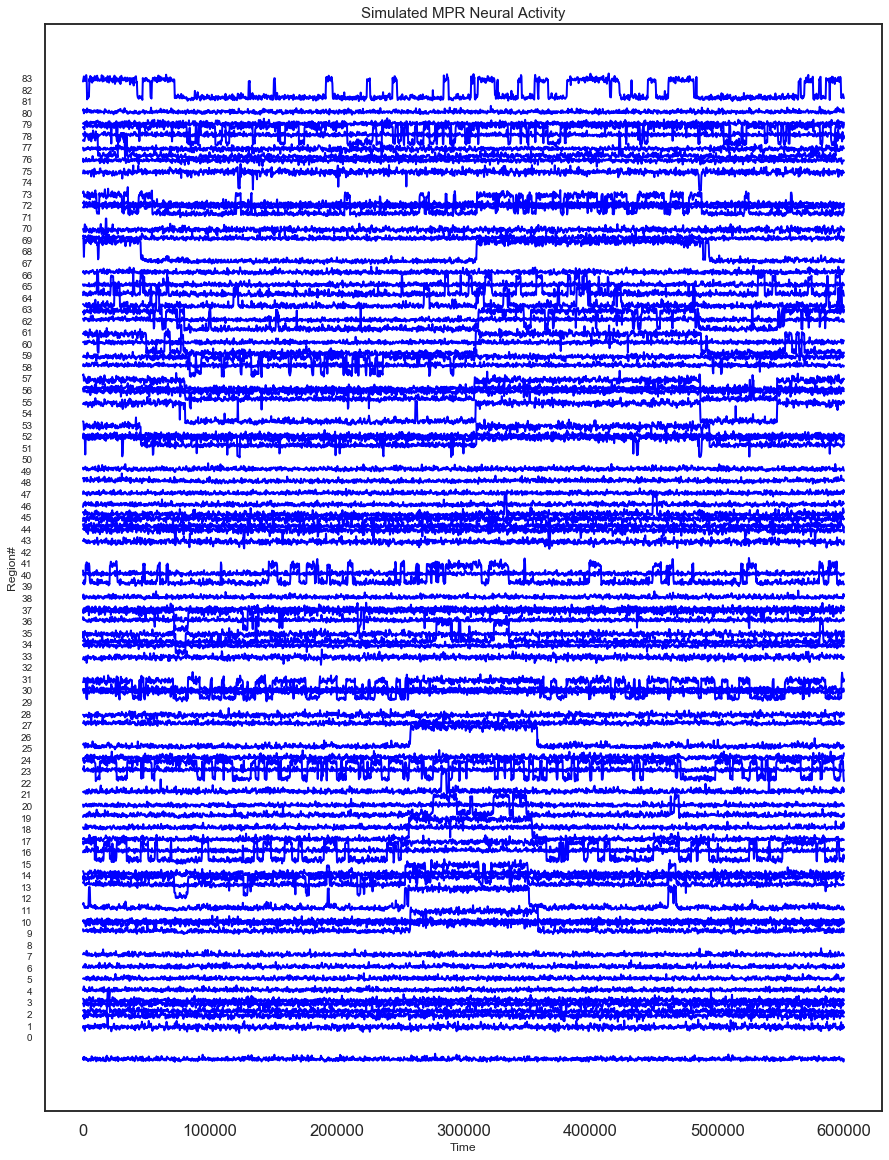

In [19]:
plt.figure(figsize=(15,20))
plt.plot(Ts, Obs_v.T + np.r_[0:nn], '-b', linewidth=2)
plt.yticks(np.r_[0:nn], np.r_[0:nn], fontsize=10)
plt.title("Simulated MPR Neural Activity",fontsize=15)
plt.xlabel('Time',fontsize=12)
plt.ylabel('Region#',fontsize=12)
plt.savefig(os.path.join(cwd+'/Figs',"MPR_SyntheticSource.png"))
plt.show()

# Selecting Some node activities 

In [20]:
Ns_=np.array([0, 16, 36, 66, 78, 83])

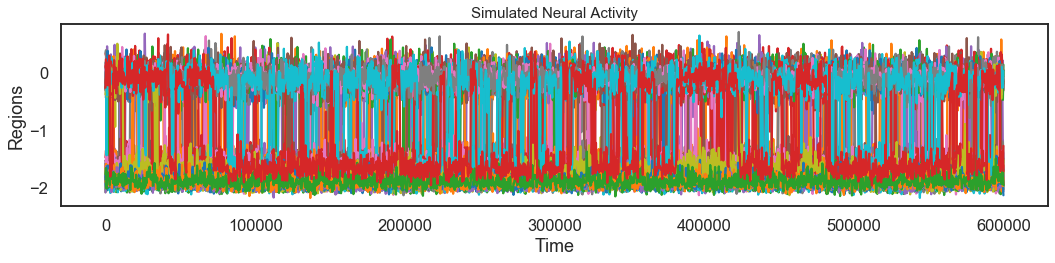

In [21]:
plt.figure(figsize=(15, 4))
plt.plot(Ts, Obs_v.T)
plt.xlabel("Time")
plt.ylabel("Regions")
plt.title("Simulated Neural Activity",fontsize=15)
plt.tight_layout()
plt.savefig(os.path.join(cwd+'/Figs',"MPR_Selected_SyntheticSource_nn.png"))
plt.show()     

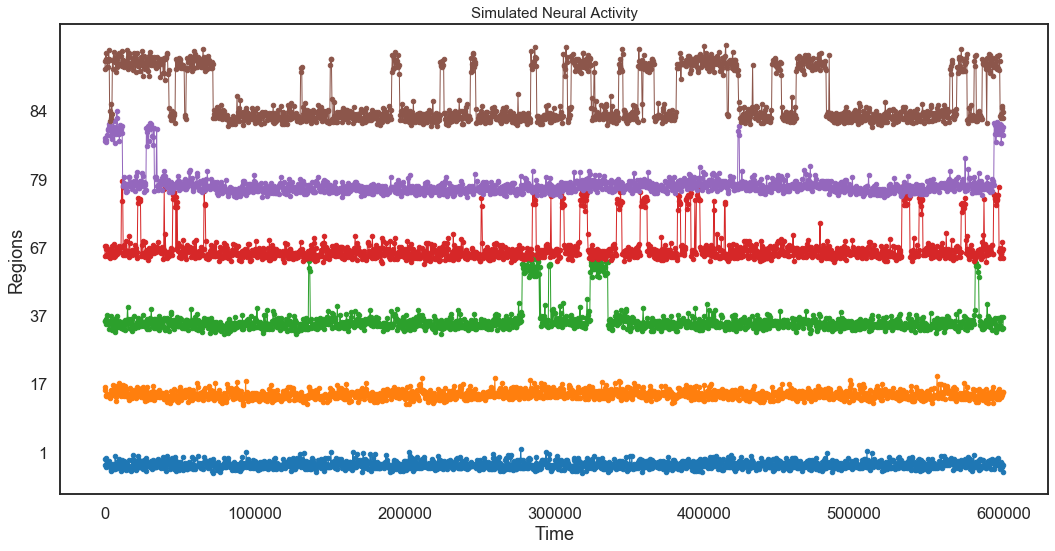

In [22]:
plt.figure(figsize=(15, 8))
i=0
for ii in (Ns_):
    i=i+1
    plt.plot(Ts, Obs_v[ii, :].T+ 2*i, '.-', lw=1)
plt.yticks(2*np.r_[0:Ns_.size]+.5, Ns_+1)
plt.xlabel("Time")
plt.ylabel("Regions")
plt.title("Simulated Neural Activity",fontsize=15)
plt.tight_layout()
plt.savefig(os.path.join(cwd+'/Figs',"MPR_Selected_SyntheticSourceNodes_nn.png"))
plt.show()     

In [23]:
Obs_v.shape, Obs_r.shape

((84, 1667), (84, 1667))

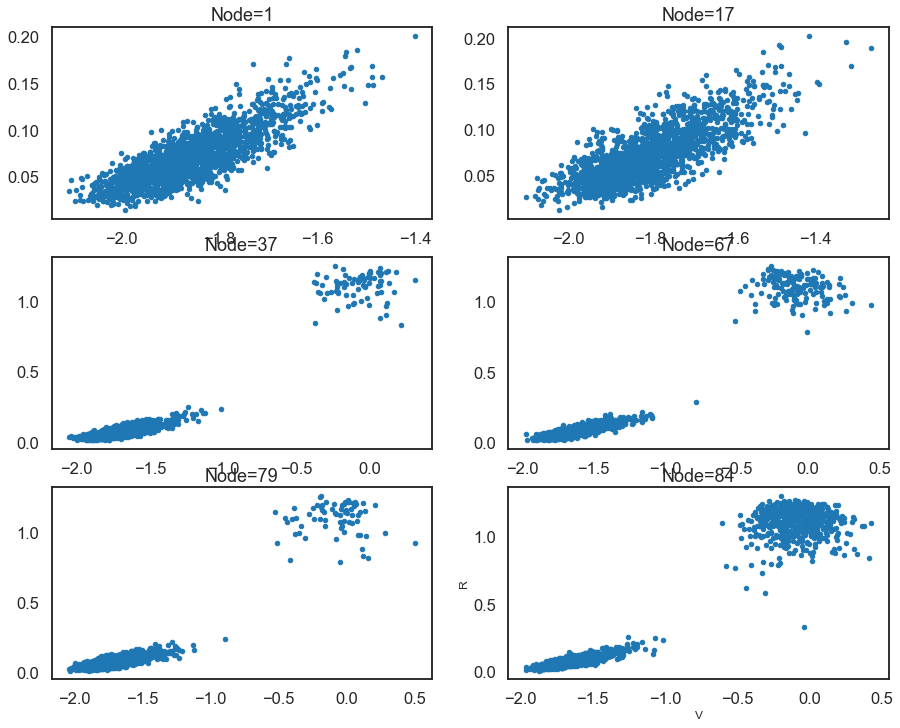

In [24]:
plt.figure(figsize=(15, 12))
i=0
for ii in (Ns_):
    i=i+1
    plt.subplot(3,2,i)
    plt.plot(Obs_v[ii, :], Obs_r[ii, :], '.', lw=.1)
    plt.title("Node={:d}".format((ii)+1))
plt.xlabel('V',fontsize=12)
plt.ylabel('R',fontsize=12)
plt.savefig(os.path.join(cwd+'/Figs',"MPR_Selected_SyntheticSourcePhasePlaneRV.png"))
plt.show()     

# Probabilistic PCA on a selected brain region

In [219]:
ns=0

In [220]:
Obs_v[ns, :].shape, Obs_r[ns, :].shape

((1667,), (1667,))

In [221]:
len(Obs_v[ns, :])

1667

In [222]:
N = len(Obs_v[ns, :])  # number of data points
D = 2  # data dimensionality
K = 1  # latent dimensionality

In [223]:
x_train=np.stack((Obs_v[ns, :]+1.86, Obs_r[ns, :]-.07))

In [224]:
x_train.shape

(2, 1667)

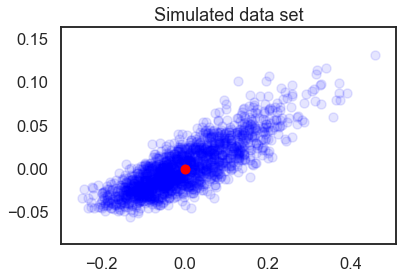

In [225]:
plt.scatter(x_train[0, :], x_train[1, :], color='blue', alpha=0.1)
#plt.axis([-2.2, -1.25, 0, .2])
plt.plot(0,0,'ro')
plt.title("Simulated data set")
plt.show()

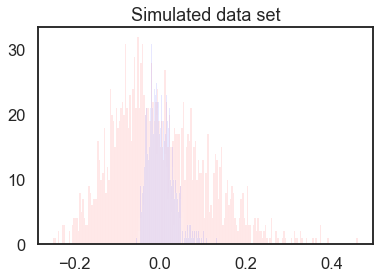

In [226]:
#plt.scatter(x_train[0, :], x_train[1, :], color='blue', alpha=0.1)
plt.hist(x_train[0, :], color='r', alpha=0.1, bins=200)
plt.hist(x_train[1, :], color='b', alpha=0.1, bins=200)
#plt.axis([-10, 10, -10, 10])
plt.title("Simulated data set")
plt.show()

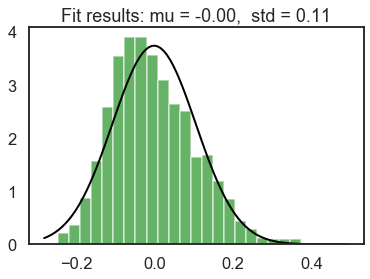

In [33]:
from scipy.stats import norm


data=x_train[0, :]

# Fit a normal distribution to the data:
mu, std = norm.fit(data)

# Plot the histogram.
plt.hist(data, bins=25, density=True, alpha=0.6, color='g')

# Plot the PDF.
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)
plt.plot(x, p, 'k', linewidth=2)
title = "Fit results: mu = %.2f,  std = %.2f" % (mu, std)
plt.title(title)

plt.show()

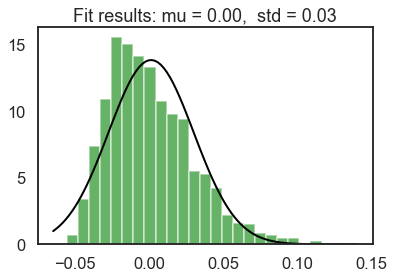

In [34]:
from scipy.stats import norm


data=x_train[1, :]

# Fit a normal distribution to the data:
mu, std = norm.fit(data)

# Plot the histogram.
plt.hist(data, bins=25, density=True, alpha=0.6, color='g')

# Plot the PDF.
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)
plt.plot(x, p, 'k', linewidth=2)
title = "Fit results: mu = %.2f,  std = %.2f" % (mu, std)
plt.title(title)

plt.show()

In [35]:
with pm.Model() as PPCA:
    w = pm.Normal('w', mu=tt.zeros([D, K]), sd=1.0 * tt.ones([D, K]), shape=[D, K])
    z = pm.Normal('z', mu=tt.zeros([N, K]), sd=1.0*tt.ones([N, K]), shape=[N, K])
    sigma = pm.HalfCauchy('sigma', beta=1.0)
    x = pm.Normal('x', mu=w.dot(z.T), sd=sigma*tt.ones([D, N]), shape=[D, N], observed=x_train)  

    trace = pm.sample(draws=2000, tune=2000)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, z, w]
Sampling 2 chains, 0 divergences: 100%|██████████| 8000/8000 [00:27<00:00, 291.14draws/s]
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


In [ ]:
#print(trace.varnames)

In [ ]:
#trace['w'].shape, trace['z'].shape

In [ ]:
# pm.traceplot(trace)
# plt.show()

In [36]:
w=np.asarray(trace.get_values('w', burn=0, combine=True))
z=np.asarray(trace.get_values('z', burn=0, combine=True))
sigma=np.asarray(trace.get_values('sigma', burn=0, combine=True))

In [37]:
w.shape, z.shape

((4000, 2, 1), (4000, 1667, 1))

In [38]:
w_est=np.mean(w, axis=0)
z_est=np.mean(z, axis=0)
sigma_est=np.mean(sigma, axis=0)

In [39]:
sigma_est

0.015869002602858926

In [40]:
w_est.shape, z_est.shape

((2, 1), (1667, 1))

In [41]:
print("Inferred principal axes:")
print(w_est)

Inferred principal axes:
[[-2.81595306e-04]
 [-6.78080297e-05]]


In [55]:
print(w_est[1]/w_est[0])

[0.24079957]


In [42]:
z_est.mean()

-5.2754385162798746e-05

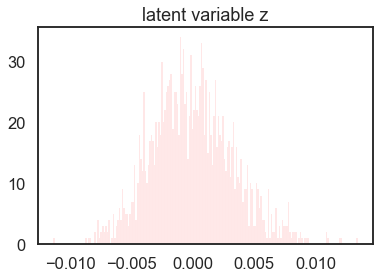

In [43]:
#plt.scatter(x_train[0, :], x_train[1, :], color='blue', alpha=0.1)
plt.hist(z_est, color='r', alpha=0.1, bins=200)
#plt.axis([-10, 10, -10, 10])
plt.title("latent variable z")
plt.show()

In [44]:
#generate trace from posterior
ppc_trace = pm.sample_posterior_predictive(trace, samples=2000, model=PPCA)

100%|██████████| 2000/2000 [00:02<00:00, 793.53it/s]


In [45]:
for key,val in ppc_trace.items():
    print (key, "=>", val)
    print (val.shape)

x => [[[-0.03857344  0.1164581  -0.08781883 ... -0.14531012 -0.21898309
   -0.00670829]
  [-0.00196394  0.04094695 -0.0300353  ...  0.00417843 -0.06834791
    0.00186927]]

 [[-0.03062474  0.11120597 -0.09816081 ... -0.09648872 -0.19404127
   -0.03590621]
  [ 0.02499639  0.02886048 -0.02058327 ...  0.00707419 -0.01932408
   -0.00706127]]

 [[-0.06882071  0.158776   -0.10127577 ... -0.10088726 -0.21724525
    0.00676437]
  [-0.02481646  0.03249674 -0.03320602 ... -0.01263169 -0.04211804
    0.00876916]]

 ...

 [[-0.02072123  0.13512338 -0.11282178 ... -0.06982727 -0.20355514
   -0.05179507]
  [-0.02865633  0.01966056 -0.04940212 ... -0.03876653 -0.04239633
   -0.02464665]]

 [[-0.04207228  0.16991143 -0.09189338 ... -0.02815409 -0.2245615
    0.00064705]
  [ 0.00933123  0.0237071  -0.02394157 ... -0.01141866 -0.06381395
   -0.03771643]]

 [[-0.03121392  0.13806343 -0.07363291 ... -0.07176928 -0.19302064
   -0.03393864]
  [-0.01144442  0.04591428 -0.02266899 ... -0.00907975 -0.03527115


In [46]:
x_gen=ppc_trace['x']

In [47]:
x_train.shape, x_gen.shape

((2, 1667), (2000, 2, 1667))

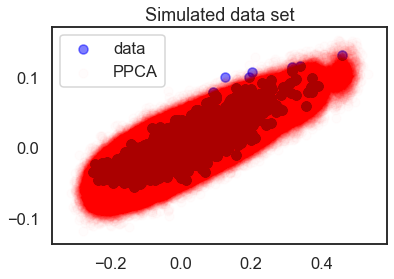

In [48]:
#plt.figure(figsize=(4, 4))
plt.scatter(x_train[0, :], x_train[1, :], color='b', alpha=0.5, label='data')
plt.scatter(x_gen[:,0, :], x_gen[:,1, :],  color='r', alpha=0.01, label='PPCA')
#plt.axis([-3.2, -.25, -2, 2])
plt.title("Simulated data set")
plt.legend()
plt.savefig(os.path.join(cwd+"/Figs","PPCA_Node_0.png"))

plt.show()

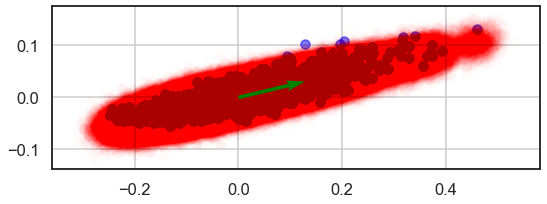

In [57]:
X = np.array((0.))
Y= np.array((0.0))
U = -w_est[0]
V = -w_est[1]

fig, ax = plt.subplots(1,1,figsize=(12,3))
plt.scatter(x_train[0, :], x_train[1, :], color='b', alpha=0.5)
plt.scatter(x_gen[:,0, :], x_gen[:,1, :],  color='r', alpha=0.01)
q = ax.quiver(X, Y, U, V,units='xy' ,scale=.0022, color='green')
plt.grid()
ax.set_aspect('equal')
# plt.xlim(-2,0)
# plt.ylim(0,1)
plt.show()

# Probabilistic PCA on a selected brain region

In [227]:
ns=36

In [228]:
Obs_v[ns, :].shape, Obs_r[ns, :].shape

((1667,), (1667,))

In [229]:
len(Obs_v[ns, :])

1667

In [230]:
N = len(Obs_v[ns, :])  # number of data points
D = 2  # data dimensionality
K = 1  # latent dimensionality

In [231]:
x_train=np.stack((Obs_v[ns, :]+1.86, Obs_r[ns, :]-.07))

In [232]:
x_train.shape

(2, 1667)

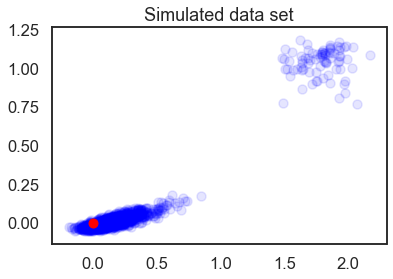

In [233]:
plt.scatter(x_train[0, :], x_train[1, :], color='blue', alpha=0.1)
#plt.axis([-2.2, -1.25, 0, .2])
plt.plot(0,0,'ro')
plt.title("Simulated data set")
plt.show()

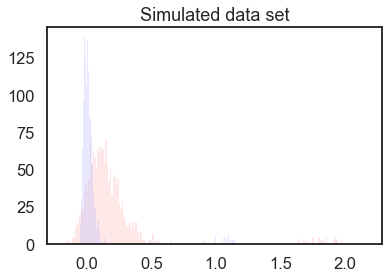

In [234]:
#plt.scatter(x_train[0, :], x_train[1, :], color='blue', alpha=0.1)
plt.hist(x_train[0, :], color='r', alpha=0.1, bins=200)
plt.hist(x_train[1, :], color='b', alpha=0.1, bins=200)
#plt.axis([-10, 10, -10, 10])
plt.title("Simulated data set")
plt.show()

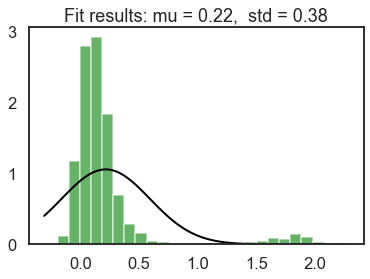

In [107]:
from scipy.stats import norm


data=x_train[0, :]

# Fit a normal distribution to the data:
mu, std = norm.fit(data)

# Plot the histogram.
plt.hist(data, bins=25, density=True, alpha=0.6, color='g')

# Plot the PDF.
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)
plt.plot(x, p, 'k', linewidth=2)
title = "Fit results: mu = %.2f,  std = %.2f" % (mu, std)
plt.title(title)

plt.show()

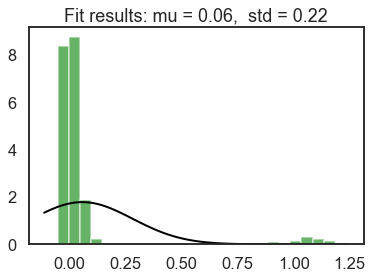

In [108]:
from scipy.stats import norm


data=x_train[1, :]

# Fit a normal distribution to the data:
mu, std = norm.fit(data)

# Plot the histogram.
plt.hist(data, bins=25, density=True, alpha=0.6, color='g')

# Plot the PDF.
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)
plt.plot(x, p, 'k', linewidth=2)
title = "Fit results: mu = %.2f,  std = %.2f" % (mu, std)
plt.title(title)

plt.show()

In [109]:
with pm.Model() as PPCA:
    w = pm.Normal('w', mu=tt.zeros([D, K]), sd=1.0 * tt.ones([D, K]), shape=[D, K])
    z = pm.Normal('z', mu=tt.zeros([N, K]), sd=1.0*tt.ones([N, K]), shape=[N, K])
    sigma = pm.HalfCauchy('sigma', beta=1.0)
    x = pm.Normal('x', mu=w.dot(z.T), sd=sigma*tt.ones([D, N]), shape=[D, N], observed=x_train)  

    trace = pm.sample(draws=2000, tune=2000)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, z, w]
Sampling 2 chains, 0 divergences: 100%|██████████| 8000/8000 [00:24<00:00, 323.19draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.


In [110]:
#print(trace.varnames)

In [111]:
#trace['w'].shape, trace['z'].shape

In [112]:
# pm.traceplot(trace)
# plt.show()

In [113]:
w=np.asarray(trace.get_values('w', burn=0, combine=True))
z=np.asarray(trace.get_values('z', burn=0, combine=True))
sigma=np.asarray(trace.get_values('sigma', burn=0, combine=True))

In [114]:
w.shape, z.shape

((4000, 2, 1), (4000, 1667, 1))

In [115]:
w_est=np.mean(w, axis=0)
z_est=np.mean(z, axis=0)
sigma_est=np.mean(sigma, axis=0)

In [116]:
sigma_est

0.07526508272525671

In [117]:
w_est.shape, z_est.shape

((2, 1), (1667, 1))

In [118]:
print("Inferred principal axes:")
print(w_est)

Inferred principal axes:
[[-0.42746569]
 [-0.21825679]]


In [119]:
print(w_est[1]/w_est[0])

[0.51058318]


In [120]:
z_est.mean()

-0.442554251016784

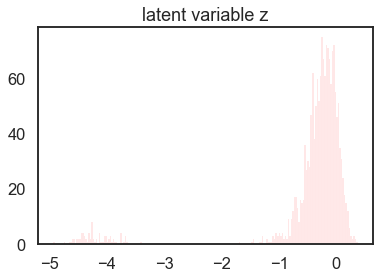

In [121]:
#plt.scatter(x_train[0, :], x_train[1, :], color='blue', alpha=0.1)
plt.hist(z_est, color='r', alpha=0.1, bins=200)
#plt.axis([-10, 10, -10, 10])
plt.title("latent variable z")
plt.show()

In [122]:
#generate trace from posterior
ppc_trace = pm.sample_posterior_predictive(trace, samples=2000, model=PPCA)

100%|██████████| 2000/2000 [00:02<00:00, 741.07it/s]


In [123]:
for key,val in ppc_trace.items():
    print (key, "=>", val)
    print (val.shape)

x => [[[ 0.0985313   0.14122297  0.10917292 ... -0.05259834 -0.16793028
    0.34063554]
  [ 0.01050157  0.26708552 -0.04077019 ...  0.0337801  -0.12028626
    0.04152229]]

 [[ 0.18970925  0.20331617  0.3339229  ... -0.10177505 -0.07070218
    0.27011436]
  [ 0.29602086  0.1494826   0.0393944  ... -0.01125977 -0.08884695
    0.01876193]]

 [[ 0.09193916  0.24888159  0.10271637 ... -0.01852232  0.05764755
    0.15399856]
  [ 0.11585531 -0.05911223  0.06871953 ...  0.0210469  -0.0645654
    0.07008007]]

 ...

 [[ 0.20540717  0.05025047 -0.00482245 ... -0.07524409  0.03156001
    0.29295799]
  [-0.02432755  0.02069709  0.01258488 ... -0.07726267 -0.01573198
    0.08102879]]

 [[ 0.17883039  0.14781343  0.0481839  ...  0.1226767  -0.03108765
   -0.03494551]
  [ 0.00800045  0.1769738   0.06014713 ... -0.03560761  0.0721279
   -0.02432602]]

 [[ 0.14462256  0.15858883  0.05433836 ... -0.09849935  0.02741593
    0.40681471]
  [ 0.1257517  -0.08657131  0.14583778 ... -0.06471451 -0.01067231
 

In [124]:
x_gen=ppc_trace['x']

In [125]:
x_train.shape, x_gen.shape

((2, 1667), (2000, 2, 1667))

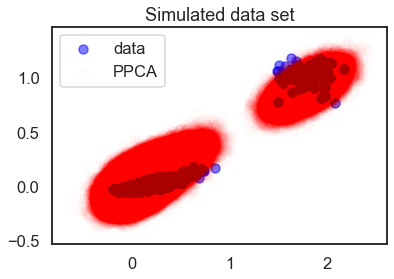

In [126]:
#plt.figure(figsize=(4, 4))
plt.scatter(x_train[0, :], x_train[1, :], color='b', alpha=0.5, label='data')
plt.scatter(x_gen[:,0, :], x_gen[:,1, :],  color='r', alpha=0.01, label='PPCA')
#plt.axis([-3.2, -.25, -2, 2])
plt.title("Simulated data set")
plt.legend()
plt.savefig(os.path.join(cwd+"/Figs","PPCA_Node_36.png"))

plt.show()

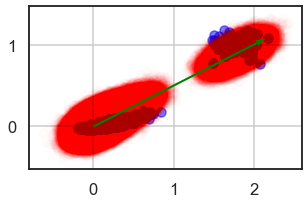

In [130]:
X = np.array((0.))
Y= np.array((0.0))
U = -w_est[0]
V = -w_est[1]

fig, ax = plt.subplots(1,1,figsize=(12,3))
plt.scatter(x_train[0, :], x_train[1, :], color='b', alpha=0.5)
plt.scatter(x_gen[:,0, :], x_gen[:,1, :],  color='r', alpha=0.01)
q = ax.quiver(X, Y, U, V,units='xy' ,scale=.2, color='green')
plt.grid()
ax.set_aspect('equal')
# plt.xlim(-2,0)
# plt.ylim(0,1)
plt.show()

# Probabilistic PCA on a selected brain region

In [235]:
ns=83

In [236]:
Obs_v[ns, :].shape, Obs_r[ns, :].shape

((1667,), (1667,))

In [237]:
len(Obs_v[ns, :])

1667

In [238]:
N = len(Obs_v[ns, :])  # number of data points
D = 2  # data dimensionality
K = 1  # latent dimensionality

In [239]:
x_train=np.stack((Obs_v[ns, :]+1.86, Obs_r[ns, :]-.07))

In [240]:
x_train.shape

(2, 1667)

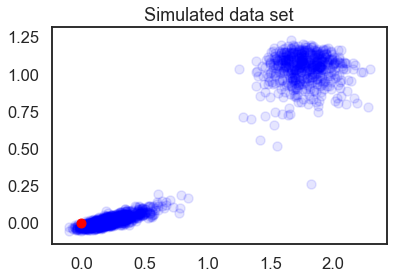

In [241]:
plt.scatter(x_train[0, :], x_train[1, :], color='blue', alpha=0.1)
#plt.axis([-2.2, -1.25, 0, .2])
plt.plot(0,0,'ro')
plt.title("Simulated data set")
plt.show()

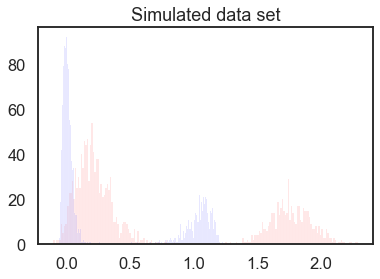

In [244]:
#plt.scatter(x_train[0, :], x_train[1, :], color='blue', alpha=0.1)
plt.hist(x_train[0, :], color='r', alpha=0.1, bins=200)
plt.hist(x_train[1, :], color='b', alpha=0.1, bins=200)
#plt.axis([-10, 10, -10, 10])
plt.title("Simulated data set")
plt.show()

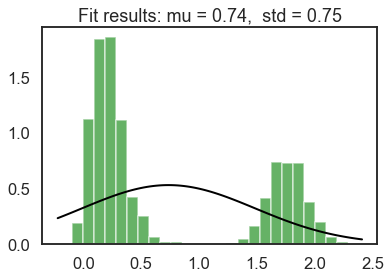

In [66]:
from scipy.stats import norm


data=x_train[0, :]

# Fit a normal distribution to the data:
mu, std = norm.fit(data)

# Plot the histogram.
plt.hist(data, bins=25, density=True, alpha=0.6, color='g')

# Plot the PDF.
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)
plt.plot(x, p, 'k', linewidth=2)
title = "Fit results: mu = %.2f,  std = %.2f" % (mu, std)
plt.title(title)

plt.show()

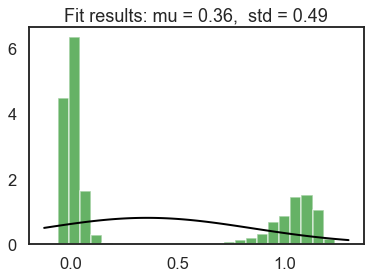

In [67]:
from scipy.stats import norm


data=x_train[1, :]

# Fit a normal distribution to the data:
mu, std = norm.fit(data)

# Plot the histogram.
plt.hist(data, bins=25, density=True, alpha=0.6, color='g')

# Plot the PDF.
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)
plt.plot(x, p, 'k', linewidth=2)
title = "Fit results: mu = %.2f,  std = %.2f" % (mu, std)
plt.title(title)

plt.show()

In [68]:
with pm.Model() as PPCA:
    w = pm.Normal('w', mu=tt.zeros([D, K]), sd=1.0 * tt.ones([D, K]), shape=[D, K])
    z = pm.Normal('z', mu=tt.zeros([N, K]), sd=1.0*tt.ones([N, K]), shape=[N, K])
    sigma = pm.HalfCauchy('sigma', beta=1.0)
    x = pm.Normal('x', mu=w.dot(z.T), sd=sigma*tt.ones([D, N]), shape=[D, N], observed=x_train)  

    trace = pm.sample(draws=2000, tune=2000)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, z, w]
Sampling 2 chains, 0 divergences: 100%|██████████| 8000/8000 [00:26<00:00, 306.85draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.


In [ ]:
#print(trace.varnames)

In [ ]:
#trace['w'].shape, trace['z'].shape

In [ ]:
# pm.traceplot(trace)
# plt.show()

In [70]:
w=np.asarray(trace.get_values('w', burn=0, combine=True))
z=np.asarray(trace.get_values('z', burn=0, combine=True))
sigma=np.asarray(trace.get_values('sigma', burn=0, combine=True))

In [71]:
w.shape, z.shape

((4000, 2, 1), (4000, 1667, 1))

In [72]:
w_est=np.mean(w, axis=0)
z_est=np.mean(z, axis=0)
sigma_est=np.mean(sigma, axis=0)

In [73]:
sigma_est

0.11429328080072822

In [74]:
w_est.shape, z_est.shape

((2, 1), (1667, 1))

In [75]:
print("Inferred principal axes:")
print(w_est)

Inferred principal axes:
[[-1.04312164]
 [-0.59487602]]


In [76]:
print(w_est[1]/w_est[0])

[0.57028443]


In [77]:
z_est.mean()

-0.6733272367256098

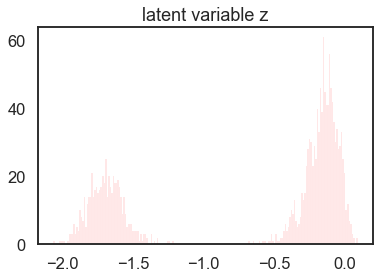

In [78]:
#plt.scatter(x_train[0, :], x_train[1, :], color='blue', alpha=0.1)
plt.hist(z_est, color='r', alpha=0.1, bins=200)
#plt.axis([-10, 10, -10, 10])
plt.title("latent variable z")
plt.show()

In [79]:
#generate trace from posterior
ppc_trace = pm.sample_posterior_predictive(trace, samples=2000, model=PPCA)

100%|██████████| 2000/2000 [00:02<00:00, 788.55it/s]


In [80]:
for key,val in ppc_trace.items():
    print (key, "=>", val)
    print (val.shape)

x => [[[ 1.63224398  1.7032403   2.16647443 ...  0.56453801  0.44738027
    0.06363668]
  [ 0.84315825  1.0006749   1.15980616 ...  0.23845621  0.26636633
    0.11134123]]

 [[ 1.51043564  1.90013063  2.03293823 ...  0.54762318  0.51832038
    0.14274808]
  [ 0.94466508  1.13687091  1.20459953 ...  0.26689402  0.10526062
    0.16044194]]

 [[ 1.52921267  1.7219686   1.80393203 ...  0.57175964  0.27519876
    0.07003702]
  [ 0.8636824   0.80583311  1.13891774 ...  0.24697395 -0.03924999
   -0.06309597]]

 ...

 [[ 1.75059953  1.94097661  1.67634708 ...  0.4297743   0.20257201
   -0.00392139]
  [ 1.0235875   0.97031364  0.77259998 ...  0.45670172  0.14720134
   -0.0586324 ]]

 [[ 1.69089925  1.68955281  2.1716661  ...  0.35638012  0.22655567
   -0.17148417]
  [ 0.78857101  1.08815244  1.09219442 ...  0.0551573   0.02803364
   -0.09396616]]

 [[ 1.99424531  1.8211658   1.96792006 ...  0.28171552  0.18976082
    0.04194556]
  [ 1.1983676   1.15646187  1.05562879 ...  0.18522334  0.0915679


In [81]:
x_gen=ppc_trace['x']

In [82]:
x_train.shape, x_gen.shape

((2, 1667), (2000, 2, 1667))

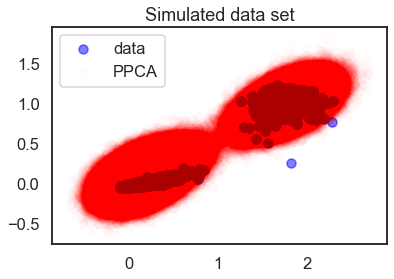

In [83]:
#plt.figure(figsize=(4, 4))
plt.scatter(x_train[0, :], x_train[1, :], color='b', alpha=0.5, label='data')
plt.scatter(x_gen[:,0, :], x_gen[:,1, :],  color='r', alpha=0.01, label='PPCA')
#plt.axis([-3.2, -.25, -2, 2])
plt.title("Simulated data set")
plt.legend()
plt.savefig(os.path.join(cwd+"/Figs","PPCA_Node_84.png"))

plt.show()

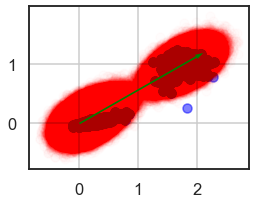

In [86]:
X = np.array((0.))
Y= np.array((0.0))
U = -w_est[0]
V = -w_est[1]

fig, ax = plt.subplots(1,1,figsize=(12,3))
plt.scatter(x_train[0, :], x_train[1, :], color='b', alpha=0.5)
plt.scatter(x_gen[:,0, :], x_gen[:,1, :],  color='r', alpha=0.01)
q = ax.quiver(X, Y, U, V,units='xy' ,scale=.5, color='green')
plt.grid()
ax.set_aspect('equal')
# plt.xlim(-2,0)
# plt.ylim(0,1)
plt.show()

# Probabilistic PCA on whole brain regions

In [245]:
Obs_v.shape, Obs_r.shape

((84, 1667), (84, 1667))

In [246]:
len(Obs_v[ns, :])

1667

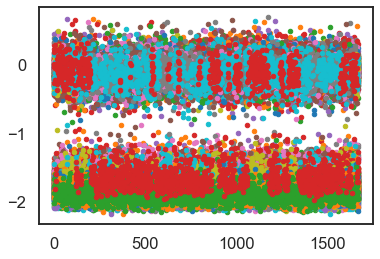

In [247]:
plt.plot(Obs_v.T,'.')
plt.show()

In [206]:
N = len(Obs_v[ns, :])  # number of data points
D = 84  # data dimensionality
K = 1  # latent dimensionality

In [248]:
x_train=np.stack((Obs_v+1.86))

In [249]:
x_train.shape

(84, 1667)

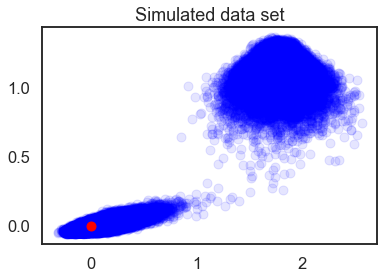

In [218]:
plt.plot(x_train[0, :, :], x_train[1,:, :], 'o', color='blue', alpha=0.1)
#plt.axis([-2.2, -1.25, 0, .2])
plt.plot(0,0,'ro')
plt.title("Simulated data set")
plt.show()

In [ ]:
with pm.Model() as PPCA:
    w = pm.Normal('w', mu=tt.zeros([D, K]), sd=1.0 * tt.ones([D, K]), shape=[D, K])
    z = pm.Normal('z', mu=tt.zeros([N, K]), sd=1.0*tt.ones([N, K]), shape=[N, K])
    sigma = pm.HalfCauchy('sigma', beta=1.0)
    x = pm.Normal('x', mu=w.dot(z.T), sd=sigma*tt.ones([D, N]), shape=[D, N], observed=x_train)  

    trace = pm.sample(draws=2000, tune=2000)


In [ ]:
#print(trace.varnames)

In [ ]:
#trace['w'].shape, trace['z'].shape

In [ ]:
# pm.traceplot(trace)
# plt.show()

In [ ]:
w=np.asarray(trace.get_values('w', burn=0, combine=True))
z=np.asarray(trace.get_values('z', burn=0, combine=True))

In [ ]:
w.shape, z.shape

In [ ]:
w_est=np.mean(w, axis=0)
z_est=np.mean(z, axis=0)

In [ ]:
w_est.shape, z_est.shape

In [ ]:
print("Inferred principal axes:")
print(w_est)

In [ ]:
z_est.mean()

In [ ]:
#plt.scatter(x_train[0, :], x_train[1, :], color='blue', alpha=0.1)
plt.hist(z_est, color='r', alpha=0.1, bins=200)
#plt.axis([-10, 10, -10, 10])
plt.title("latent variable z")
plt.show()

In [ ]:
#generate trace from posterior
ppc_trace = pm.sample_posterior_predictive(trace, samples=2000, model=PPCA)

In [ ]:
for key,val in ppc_trace.items():
    print (key, "=>", val)
    print (val.shape)

In [ ]:
x_gen=ppc_trace['x']

In [ ]:
x_train.shape, x_gen.shape

In [ ]:
#plt.figure(figsize=(4, 4))
plt.scatter(x_train[0, :], x_train[1, :], color='b', alpha=0.5)
plt.scatter(x_gen[:,0, :], x_gen[:,1, :],  color='r', alpha=0.01)
#plt.axis([-3.2, -.25, -2, 2])
plt.title("Simulated data set")
plt.show()

In [ ]:
X = np.array((0.))
Y= np.array((0.0))
U = -w_est[0]
V = -w_est[1]

fig, ax = plt.subplots(1,1,figsize=(12,3))
plt.scatter(x_train[0, :], x_train[1, :], color='b', alpha=0.8)
q = ax.quiver(X, Y, U, V,units='xy' ,scale=.22, color='r')
plt.grid()
ax.set_aspect('equal')
# plt.xlim(-2,0)
# plt.ylim(0,1)
plt.show()

In [ ]:
ppc_5=np.percentile(x_gen, [50], axis=0)
ppc_95=np.percentile(x_gen, [97.5], axis=0)

In [ ]:
ppc_5.shape

In [ ]:
plt.scatter(x_train[0, :], x_train[1, :], color='b', alpha=0.8)
plt.scatter(ppc_5[0,0,:], ppc_5[0,1,:], color='r', alpha=0.01)
plt.show()